# YOLO (You Only Look at Once)
"You Only Look Once" (YOLO) 모델은 object detection을 위한 성능이 좋으면서도 예측이 실시간으로 가능할정도로 빠른 매우 유명한 모델이다. 이 알고리즘은 이미지를 "단 한번만 보며 (only looks once)", 즉 단 한번의 forward propagation만으로 예측을 수행한다.

이번 실습에서는 YOLO v1 모델을 직접 구현하여 object detection을 수행해본다

(YOLOv1에서 target을 수정한 변형된 버전임)

<img src="resources/yolo_fig1.png" style="width:600px;height:200;">


### inputs and outputs(target)
Object detection이란 이미지를 입력으로 받아 물체의 존재유무를 검출하고 검출된 object에 대응하는 bounding box를 찾는 문제이다.
아래 이미지는 YOLO의 target을 도식화한 것으로 box의 중심 $b_x$, $b_y$와 너비와 높이 $b_w$와 $b_h$를 찾는것이 목표이다.

<img src="resources/yolo_box_label.png" style="width:500px;height:250;">

이와 더불어 YOLO 모델에서는 object 존재 유무에 대한 confidence값 $p_c$와 검출된 물체가 어떤 class에 속하는지에 대한 $c$값도 함께 학습한다.

만약 검출하고자 하는 물체의 종류가 20가지라면 class label $c$는 0부터 19사이의 정수로 표현될 수도 있고, class에 대응하는 길이 20의 one-hot encoding vector로 표현될 수도 있다.

정리하자면 하나의 bounding box에 대한 target $y$는 25개의 숫자 $(x, y, h, w, p_c, c_1, c_2, ..., c_{20})$ 로 표현된다

### S x S grid cells

YOLO에서는 이미지가 $S \times S$ 개의 grid cell로 분할되며, 각 grid cell은 box의 개수 $B$ 개만큼의 물체를 검출하는 역할이 주어진다. 즉 YOLO는 최대 $S \times S \times B$ 개의 물체를 검출할 수 있다.

각 grid cell이 담당하는 물체는 어떻게 할당 될까? 어떤 grid cell이 물체를 둘러싸는 bounding box의 중심을 포함하고 있으면 해당 물체는 그 grid cell에 할당되게 된다. 

예를 들어 아래 그림에서 개의 중심은 빨간색으로 표기된 grid cell에 포함되므로 해당 grid cell이 개의 검출을 담당하게 된다.

<img src="resources/yolo_grid_cell.png" style="width:400px;height:200;">

따라서 한개 이지미에 대한 target tensor는 $(S, S, B, 25)$ 의 shape을 같게 되며 $S = 7, B = 2$일때는 아래 그림과 같은 모양을 가진다.

<img src="resources/yolo_target.jpg" style="width:600px;height:200;">


### Bounding Box representation

물체를 둘러싸는 bounding box는 (center x, center y, width, height)의 4개 값으로 표현된다

* $x$와 $y$값은 grid cell 내에서의 상대적인 위치 값으로 항상 $[0,1]$사이의 값을 가진다
* $w$와 $h$는 grid cell 크기에 대한 상대적인 값으로 1보다 큰 값을 가질 수 있다.

아래 이미지에 이에 대한 설명이 잘 표현되어 있다

<img src="resources/yolo_bb.png" style="width:500px;height:200;">

### Object confidence and class score
Object condifence score $p_c$는 물체가 존재할 확률 $P(Object)$에 대한 예측값이다.
또한 class score $c_i$는 물체가 존재할 경우 그 물체가 $class_i$일 확률 $P(Class_i|Object)$에 대한 예측 값이다.

이 두 값의 곱을 통해서 class-specific confidence score를 계산할 수 있다
$$P(Class_i) = P(Class_i|Object) \times P(Object) = p_c \times c_i$$



In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, models
import torchvision.transforms as transforms

import wandb
import pprint
from tqdm import tqdm

from training_utilities import create_dataloaders, train_loop, AverageMeter, save_checkpoint, load_checkpoint

Pytorch에서 제공하는 Pascal VOC 2012 데이터셋을 이용해 이미지와 타겟을 읽어보자

In [2]:
data_root_dir = '/datasets'

voc_train_dataset = datasets.VOCDetection(root=data_root_dir, year='2012', image_set='train', download=False,
                                          transform = transforms.ToTensor())

아래와 같이 이미지와 dictionary로 된 label값이 리턴되는것을 확인할 수 있다.

In [3]:
i = 0
print(f"{i+1}-th example")
print(f" - image shape: {voc_train_dataset[i][0].shape}. ")
print(f" - label: ")
pprint.PrettyPrinter().pprint(voc_train_dataset[i][1])


1-th example
 - image shape: torch.Size([3, 442, 500]). 
 - label: 
{'annotation': {'filename': '2008_000008.jpg',
                'folder': 'VOC2012',
                'object': [{'bndbox': {'xmax': '471',
                                       'xmin': '53',
                                       'ymax': '420',
                                       'ymin': '87'},
                            'difficult': '0',
                            'name': 'horse',
                            'occluded': '1',
                            'pose': 'Left',
                            'truncated': '0'},
                           {'bndbox': {'xmax': '289',
                                       'xmin': '158',
                                       'ymax': '167',
                                       'ymin': '44'},
                            'difficult': '0',
                            'name': 'person',
                            'occluded': '0',
                            'pose': 'Unspecified',
  

### <mark>실습</mark> YOLODataset
`VOCDetection` 데이터셋의 이미지와 label을 입력으로 받아 YOLO를 위한 이미지와 YOLO target 텐서를 리턴하는 데이터셋 `YOLODataset`을 완성하라. 

- 하나의 grid cell에 여러개의 object가 할당되는 경우 처음 B개까지의 물체만 target 텐서에 할당 할 것.
- image shape이 (# channel, width, height)가 아니라 (# channel, height(y), width(x))임에 주의하고, target 텐서도 이와 같은 순서로 구성할 것.
- transform은 추후에 사용할 것이므로 현재 구현에서는 이미지나 타겟에 적용하지 말것.

In [4]:
class YOLODataset(Dataset):
    def __init__(self, voc_dataset, S=7, B=2, transform=None):
        self.voc_dataset = voc_dataset
        self.S = S   # Number of grids (e.g., 7 for YOLOv1)
        self.B = B   # Number of bounding boxes per grid cell
        self.transform = transform

        self.classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                        "bus", "car", "cat", "chair", "cow", "diningtable",
                        "dog", "horse", "motorbike", "person", "pottedplant",
                        "sheep", "sofa", "train", "tvmonitor"]

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        image, label = self.voc_dataset[idx]

        objects = label['annotation']['object']
        image_width = float(label['annotation']['size']['width'])
        image_height = float(label['annotation']['size']['height'])

        ##### YOUR CODE START #####
        target = torch.zeros(self.S, self.S, self.B, 4+1+len(self.classes)) # target 초기화
        
        for obj in objects:
            bnd = obj['bndbox']
            xmin = float(bnd['xmin'])
            xmax = float(bnd['xmax'])
            ymin = float(bnd['ymin'])
            ymax = float(bnd['ymax'])
            class_idx = self.classes.index(obj['name'])

            x_center = (xmax+xmin)/2 # 바운딩 박스의 x 중앙 좌표
            y_center = (ymax+ymin)/2 # 바운딩 박스의 y 중앙 좌표
            width = xmax-xmin # 바운딩 박스의 너비
            height = ymax-ymin # 바운딩 박스의 높이

            # nomalize with respoect to image size
            x_center /= image_width
            y_center /= image_height
            width /= image_width
            height /= image_height

            # find grid cell index
            grid_x = int(x_center * self.S)
            grid_y = int(y_center * self.S)
            grid_width = width*self.S
            grid_height = height*self.S

            # nomalize with respect to grid cell size
            x_cell = x_center * self.S - grid_x
            y_cell = y_center * self.S - grid_y

            # use first B boxes
            for b in range(self.B):
                if target[grid_y, grid_x, b, 4] == 0:  # 비어 있는 바운딩 박스 슬롯을 찾음, confidence가 0인 경우 바운딩 박스 사용 x
                    target[grid_y, grid_x, b, 0:4] = torch.tensor([x_cell, y_cell, grid_width, grid_height])
                    target[grid_y, grid_x, b, 4] = 1  # confidence score = 1
                    target[grid_y, grid_x, b, 5 + class_idx] = 1
                    break  # B개의 바운딩 박스를 초과하지 않도록 break
        
        ##### YOUR CODE END #####

        return image, target


In [5]:
def load_VOC_YOLO_datasets(data_root_dir, S, B):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    train_transforms = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])
    
    voc_train_dataset = datasets.VOCDetection(root=data_root_dir, year='2012', image_set='train', download=False,
                                              transform = train_transforms)
    voc_test_dataset = datasets.VOCDetection(root=data_root_dir, year='2012', image_set='val', download=False,
                                             transform = test_transforms)
    
    train_dataset = YOLODataset(voc_train_dataset, S= S, B = B)
    test_dataset = YOLODataset(voc_test_dataset, S= S, B = B)


    return train_dataset, test_dataset

In [6]:
train_dataset, test_dataset = load_VOC_YOLO_datasets(data_root_dir, S = 7, B = 2)

In [7]:
i = 3
X, y = train_dataset[i]
print(f"{i+1}-th example X.shape : {X.shape}, y.shape: {y.shape}")
print(f"target value at grid (1, 3) : {y[1][3]}")

4-th example X.shape : torch.Size([3, 224, 224]), y.shape: torch.Size([7, 7, 2, 25])
target value at grid (1, 3) : tensor([[0.3634, 0.8410, 6.4745, 3.6540, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2162, 0.0150, 0.6727, 1.0220, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


**Expected output:**
```
4-th example X.shape : torch.Size([3, 224, 224]), y.shape: torch.Size([7, 7, 2, 25])
target value at grid (1, 3) : tensor([[0.3634, 0.8410, 6.4745, 3.6540, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.2162, 0.0150, 0.6727, 1.0220, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
```


몇개 이미지와 bounding box를 같이 visualize해보자.

In [8]:
import matplotlib.pyplot as plt
import cv2  # You can use PIL too if you prefer

def visualize_image_with_bboxes(image, target, S=7, B=2, class_names=None, confidence_threshold=0.5):
    """
    Visualizes an image with bounding boxes drawn over it.
    
    Args:
    - image (Tensor): Image tensor (C, H, W).
    - target (Tensor): The corresponding YOLOv1 target tensor (S, S, B * (5 + num_classes)).
    - S (int): Grid size (default 7).
    - B (int): Number of bounding boxes per grid cell (default 2).
    - class_names (list): List of class names.
    - confidence_threshold (float): Minimum confidence score to display bounding boxes.
    """
    if isinstance(image, torch.Tensor):
        # Undo normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).to(image.device).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).to(image.device).view(-1, 1, 1)
        image = image * std + mean

        image = image.permute(1, 2, 0).cpu().numpy() # Convert tensor to numpy (C, H, W) to (H, W, C)#

    img_copy = (image * 255).astype(np.uint8).copy()

    height, width = image.shape[:2]

    # Iterate over grid cells
    for grid_row in range(S):
        for grid_col in range(S):
            for box_index in range(B):
                # Extract confidence for this box
                confidence = target[grid_row, grid_col, box_index, 4]
                
                if confidence > confidence_threshold:
                    # Extract bounding box details
                    x_center_cell, y_center_cell, box_width_cell, box_height_cell = target[grid_row, grid_col, box_index, :4]
                    
                    # Convert the grid-relative coordinates to image coordinates
                    x_center = (x_center_cell + grid_col) / S * width
                    y_center = (y_center_cell + grid_row) / S * height
                    box_width = box_width_cell / S * width
                    box_height = box_height_cell / S * height

                    # Convert center coordinates to top-left corner (x_min, y_min)
                    x_min = int(x_center - box_width / 2)
                    y_min = int(y_center - box_height / 2)
                    x_max = int(x_center + box_width / 2)
                    y_max = int(y_center + box_height / 2)

                    # Find the predicted class (one-hot encoded class probabilities)
                    class_probs = target[grid_row, grid_col, box_index, 5:]
                    class_idx = torch.argmax(class_probs).item()
                    class_name = class_names[class_idx]

                    # Draw bounding box and label on the image using OpenCV
                    cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
                    cv2.putText(img_copy, f'{class_name} ({confidence:.2f})', (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Display the image with bounding boxes
    plt.figure() #figsize=(8, 8)
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

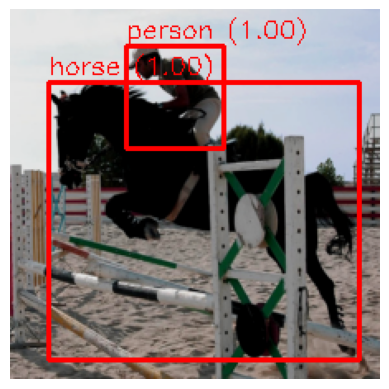

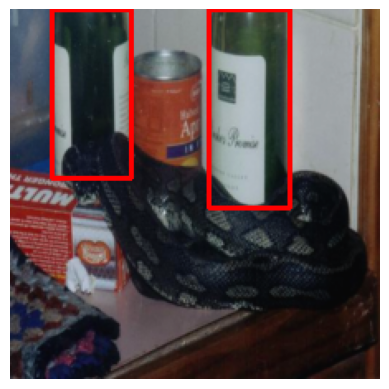

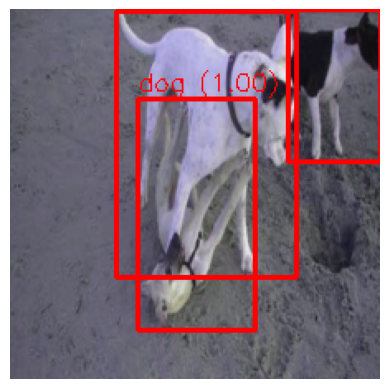

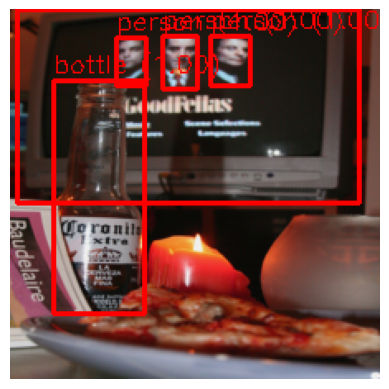

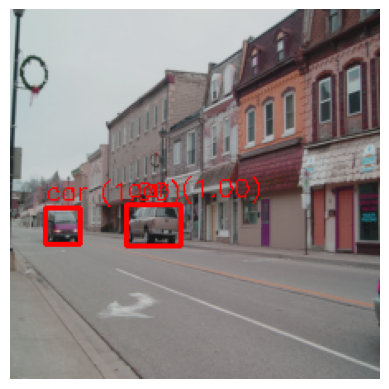

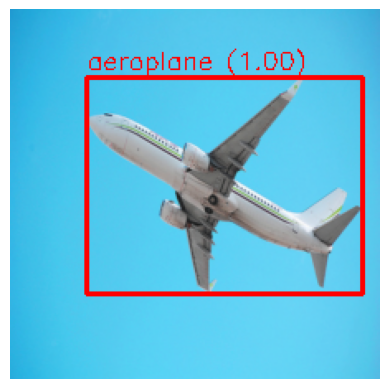

In [9]:
for i in range(len(train_dataset)):
    image, target = train_dataset[i]
    visualize_image_with_bboxes(image, target, S=7, B=2, class_names=train_dataset.classes)
    if i == 5:
        break

### YOLO Loss
YOLO loss $L$은 아래와 같이 4개의 요소로 구성되어 있다

1. **Localization Loss** (for box coordinates $x$, $y$, $w$, and $h$):
   $$
   L_{\text{coord}} = \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{\text{obj}}^{ij} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] + \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{\text{obj}}^{ij} \left[ \left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)^2 + \left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)^2 \right]
   $$

   where:
   - $1_{\text{obj}}^{ij}$ is an indicator function that is 1 if object is present in bounding box $j$ of grid cell $i$.
   - $(x_i, y_i, w_i, h_i)$ are the predicted box parameters for box $j$ in grid cell $i$.

2. **Object Confidence Loss** (for boxes containing objects):
   $$
   L_{\text{obj}} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{\text{obj}}^{ij} \left( C_{ij} - \hat{C}_{ij} \right)^2
   $$

   where:
   - $C_{ij}$ is the predicted confidence score for bounding box $j$ in grid cell $i$.
   - $\hat{C}_{ij}$ is the ground truth confidence for box $j$.

3. **No Object Confidence Loss** (for boxes without objects):
   $$
   L_{\text{noobj}} = \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{\text{noobj}}^{ij} \left( C_{ij} - \hat{C}_{ij} \right)^2
   $$

   where:
   - $1_{\text{noobj}}^{ij}$ is 1 if there is no object in grid cell $i$ and box $j$.

4. **Class Probability Loss** (for predicting the correct class probabilities for boxes that contain objects):
   $$
   L_{\text{class}} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{\text{obj}}^{ij} \sum_{c=0}^{C} \left( p_{ij}(c) - \hat{p}_{ij}(c) \right)^2
   $$

   where:
   - $p_{ij}(c)$ is the predicted probability of class $c$ for bounding box $j$ in grid cell $i$.
   - $\hat{p}_{ij}(c)$ is the one-hot encoded ground truth class probability for box $j$ in grid cell $i$.

#### Total Loss:
The total loss $L$ is the sum of all the components:
$$
L = L_{\text{coord}} + L_{\text{obj}} + L_{\text{noobj}} + L_{\text{class}}
$$

### <mark>실습</mark> YOLOLoss
YOLO loss를 계산하는 `YOLOLoss` 모듈을 완성하라
- For loop를 사용하면 계산이 매우 느려지므로 tensor 연산만을 이용하여 구현할것.

In [10]:
class YOLOLoss(nn.Module):
    def __init__(self, lambda_coord=5, lambda_noobj=0.5):
        super().__init__()
        self.lambda_coord = lambda_coord  # Weight for localization loss
        self.lambda_noobj = lambda_noobj  # Weight for no-object confidence loss
        
        self.mse = nn.MSELoss(reduction="sum")  # MSE loss for coordinates and confidence

    def forward(self, predictions, target):
        """
        predictions and target have shape (batch_size, S, S, B, 5 + C)
        elements for each grid cell and box = [x, y, w, h, confidence, class1, class2, ..., classC]
        """
        
        # Extract (x, y, w, h, confidence)
        pred_xy = predictions[..., :2]  # (x_center, y_center)
        target_xy = target[..., :2]  # (x_center, y_center)

        pred_wh = torch.sign(predictions[..., 2:4]) * torch.sqrt(torch.abs(predictions[..., 2:4] + 1e-6)) # Retain sign while applying sqrt on width and height
        target_wh = target[..., 2:4].sqrt() # sqrt(w), sqrt(h) to stabilize large boxes

        pred_confidence = predictions[..., 4]  # Object confidence
        target_confidence = target[..., 4]

        pred_class_probs = predictions[..., 5:]  # Class probabilities
        target_class_probs = target[..., 5:]

        # Create mask for cells containing objects
        obj_mask = target_confidence > 0  # Mask for cells where objects exist
        noobj_mask = target_confidence == 0  # Mask for cells where no objects exist

        ##### YOUR CODE START #####

        # 1. Localization Loss (x, y, w, h)
        loc_loss = self.mse(pred_xy[obj_mask], target_xy[obj_mask]) + self.mse(pred_wh[obj_mask], target_wh[obj_mask])
        loc_loss *= self.lambda_coord  # Scale by lambda_coord

        # 2. Object Confidence Loss (for cells with objects)
        obj_conf_loss = self.mse(pred_confidence[obj_mask], target_confidence[obj_mask])

        # 3. No Object Confidence Loss (for cells without objects)
        noobj_conf_loss = self.mse(pred_confidence[noobj_mask], target_confidence[noobj_mask])
        noobj_conf_loss *= self.lambda_noobj  # Scale by lambda_noobj

        # 4. Class Probability Loss (for cells with objects)
        class_loss = self.mse(pred_class_probs[obj_mask], target_class_probs[obj_mask])

        # Total loss
        total_loss = loc_loss + obj_conf_loss + noobj_conf_loss + class_loss

        ##### YOUR CODE END #####

        return total_loss


In [11]:
X, target = train_dataset[3]
torch.manual_seed(1004) 
y_pred = torch.randn_like(target)

print(f"Your loss : ", YOLOLoss()(y_pred.unsqueeze(0), target.unsqueeze(0)).item())

Your loss :  476.0494079589844


**Expected output**:

Your loss :  476.0494079589844

### Visualizing bounding boxes of YOLO prediction
YOLO 예측 결과를 모두 bounding box로 그려보면 아래와 같은 이미지를 얻을 수 있다.

<img src="resources/yolo_bb_wo_nms.png" style="width:300px;">

만약 모든 grid cell에서 bounding box를 예측한다면 $7\times7\times2 = 98$개의 box를 단 한번의 forward pass로 얻을 수 있다.

위 이미지를 살펴보면 YOLO예측으로 과하게 많은 bounding box 출력됨을 확인할 수 있다. 이를 줄이기 위해서는 서로 겹치는 bbox를 제거하는 **non-max suppression**이라는 알고리즘이 사용된다.

이를 위해서 먼저 IoU (Intersection over Union)값을 계산하는 함수를 구현하자.

<img src="resources/yolo_iou.png" style="width:600px;">


### <mark>실습</mark> convert_midpoint_to_corner_bboxes
[center x, center y, box width, box height]로 bounding box를 표현하는 midpoint coordinate에서 [x_min, y_min, x_max, y_max]로 bounding box를 표현하는 corner coordinate로 변환하는 함수 `convert_midpoint_to_corner_bboxes`를 완성하라

- `bboxes_midpoint_coords`의 각 값은 YOLODataset의 target tensor와 달리 **전체 이미지 크기**를 기준으로 normalize되어 모두 [0, 1] 사이의 값을 가진다.

In [12]:
def convert_midpoint_to_corner_bboxes(bboxes_midpoint_coords: torch.Tensor) -> torch.Tensor:
    """
    Convert bounding boxes from midpoint format [x_center, y_center, width, height]
    to corner format [xmin, ymin, xmax, ymax].

    Parameters:
        bboxes_midpoint_coords: 
            A tensor of shape (batch_size, 4) containing bounding boxes in midpoint format.
            Each bounding box is represented by four values [x_center, y_center, width, height] and all the four values are already normalized relative to the entire image having values between [0, 1].
    Returns:
        torch.Tensor:
            A tensor of shape (batch_size, 4) containing bounding boxes in corner format.
            Each bounding box is represented by four values:
                - xmin: x-coordinate of the top-left corner (normalized between 0 and 1).
                - ymin: y-coordinate of the top-left corner (normalized between 0 and 1).
                - xmax: x-coordinate of the bottom-right corner (normalized between 0 and 1).
                - ymax: y-coordinate of the bottom-right corner (normalized between 0 and 1).
    

    Example:
        >>> bboxes_midpoint_coords = torch.tensor([[0.5, 0.5, 0.4, 0.4]])
        >>> convert_midpoint_to_corner_bboxes(bboxes_midpoint_coords)
        tensor([[0.3000, 0.3000, 0.7000, 0.7000]])
    """

    ##### YOUR CODE START #####
    x_center = bboxes_midpoint_coords[:, 0]
    y_center = bboxes_midpoint_coords[:, 1]
    width = bboxes_midpoint_coords[:, 2]
    height = bboxes_midpoint_coords[:, 3]

    xmin = x_center - width / 2
    ymin = y_center - height / 2
    xmax = x_center + width / 2
    ymax = y_center + height / 2

    bb_corners = torch.stack((xmin, ymin, xmax, ymax), dim=1)    
    ##### YOUR CODE END #####

    return bb_corners

In [13]:
convert_midpoint_to_corner_bboxes(torch.tensor([[0.5, 0.5, 0.4, 0.4]]))

tensor([[0.3000, 0.3000, 0.7000, 0.7000]])

**Expected output:**
```
tensor([[0.3000, 0.3000, 0.7000, 0.7000]])
```


### <mark>실습</mark> Intersection over Union

IoU값을 계산하는 함수 `intersection_over_union`를 완성하라
- corner coordinate에서는 (0,0) 이 이미지의 왼쪽 위를, (1,0)이 오른쪽 위를, (1,1)이 오른쪽 아래를 지칭한다.
- 두 box의 **intersection** $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$를 구하기 위해서는:
    - `xi1` = **max**imum of the x1 coordinates of the two boxes
    - `yi1` = **max**imum of the y1 coordinates of the two boxes
    - `xi2` = **min**imum of the x2 coordinates of the two boxes
    - `yi2` = **min**imum of the y2 coordinates of the two boxes
- 두 박스가 **intersection이 없을** 수도 있다. 이는 높이 $(yi_2 - yi_1)$ 혹은 너비 $(xi_2 - xi_1)$ 중 하나 이상이 음수인지 여부로 확인할 수 있으며, 이 경우 intersection area값이 0이다.
- 두 박스가 **edges 혹은 vertices**에서 만날수도 있다. 이는 높이 $(yi_2 - yi_1)$ 혹은 너비 $(xi_2 - xi_1)$ 값이 0인지 여부로 확인할 수 있으며 이 경우에도 마찬가지로 intersection area값이 0이다.

<details>
    <summary>Additional Hints</summary>
  
  intersection area값 계산에 `max(height, 0)` 와 `max(width, 0)` 값을 사용하면 계산이 편리하다
</details>

In [14]:

def intersection_over_union(boxes_preds, boxes_targets):
    """
    Calculate the Intersection over Union (IoU) between predicted and target bounding boxes.
    
    Parameters:
        boxes_preds (torch.Tensor):
            Predicted bounding boxes with shape (batch_size, 4) in midpoint format
            [x_center, y_center, width, height]. Values are normalized between 0 and 1.
        boxes_targets (torch.Tensor):
            Ground truth bounding boxes with shape (batch_size, 4) in midpoint format
            [x_center, y_center, width, height]. Values are normalized between 0 and 1.
    
    Returns:
        torch.Tensor: Intersection over union for all examples with shape (batch_size, 1)

    Note:
        - If the boxes do not overlap, the intersection area will be zero, resulting in an IoU of zero.
        - A small epsilon (1e-6) is added to the denominator to prevent division by zero.
    """
    
    box1 = convert_midpoint_to_corner_bboxes(boxes_preds)
    box2 = convert_midpoint_to_corner_bboxes(boxes_targets)

    # Obtain x1, y1, x2, y2 tensor with shape (batch_size, 1).
    box1_x1 = box1[..., 0:1]
    box1_y1 = box1[..., 1:2]
    box1_x2 = box1[..., 2:3]
    box1_y2 = box1[..., 3:4] 
    box2_x1 = box2[..., 0:1]
    box2_y1 = box2[..., 1:2]
    box2_x2 = box2[..., 2:3]
    box2_y2 = box2[..., 3:4]

    ##### YOUR CODE START #####      
    xi1 = torch.maximum(box1_x1, box2_x1)
    yi1 = torch.maximum(box1_y1, box2_y1)
    xi2 = torch.minimum(box1_x2, box2_x2)
    yi2 = torch.minimum(box1_y2, box2_y2)

    inter_width = torch.maximum(xi2 - xi1, torch.tensor(0.0, device=xi1.device))
    inter_height = torch.maximum(yi2 - yi1, torch.tensor(0.0, device=yi1.device))
    intersection = inter_width * inter_height

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    
    ##### YOUR CODE END #####

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [15]:
# BEGIN UNIT TEST
## Test case 1: boxes intersect
box1 = torch.tensor([[3, 2, 2, 2]]) # torch.tensor([[2, 1, 4, 3]])
box2 = torch.tensor([[2, 3, 2, 2]]) #torch.tensor([[1, 2, 3, 4]])

print("iou for intersecting boxes = " + str(intersection_over_union(box1, box2)))
assert intersection_over_union(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(intersection_over_union(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: boxes do not intersect
box1 = torch.tensor([[2, 3, 2, 2]])# torch.tensor([[1,2,3,4]])
box2 = torch.tensor([[6, 7, 2, 2]])# torch.tensor([[5,6,7,8]])
print("iou for non-intersecting boxes = " + str(intersection_over_union(box1,box2)))
assert intersection_over_union(box1, box2) == 0, "Intersection must be 0"

## Test case 3: boxes intersect at vertices only
box1 = torch.tensor([[1.5, 1.5, 1, 1]]) # torch.tensor([[1,1,2,2]])
box2 = torch.tensor([[2.5, 2.5, 1, 1]]) # torch.tensor([[2,2,3,3]])
print("iou for boxes that only touch at vertices = " + str(intersection_over_union(box1,box2)))
assert intersection_over_union(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: boxes intersect at edge only
box1 = torch.tensor([[2, 2, 2, 2]]) # torch.tensor([[1,1,3,3]])
box2 = torch.tensor([[2.5, 3.5, 1, 1]]) # torch.tensor([[2,3,3,4]])
print("iou for boxes that only touch at edges = " + str(intersection_over_union(box1,box2)))
assert intersection_over_union(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")
# END UNIT TEST

iou for intersecting boxes = tensor([[0.1429]])
iou for non-intersecting boxes = tensor([[0.]])
iou for boxes that only touch at vertices = tensor([[0.]])
iou for boxes that only touch at edges = tensor([[0.]])
 All tests passed!


### Nom-max suppression (NMS)
Nom-max suppression은 크게 두 과정으로 이루어져 있다.

1. Object condifence score $p_c$ 가 특정 기준값(confidence_threshold) 보다 낮은 bounding box를 모두 제거한다.
2. IoU값이 특정 기준값 (iou_threshold) 이상으로 서로 겹치는 bounding box중 하나만 남기고 모두 제거한다.

<img src="resources/yolo_non-max-suppression.png" style="width:600px;height:400;">

위 그림을 살펴보면 YOLO model에 3개의 자동차를 검출하였지만 사실 모두 같은 자동차이다. Running non-max suppression (NMS) 알고리즘을 사용하면 이중에 가장 정확한 (highest probability) bounding box를 하나 고르게 된다.

좀더 구체적으로는 아래와 같은 과정으로 이루어진다.
1. $p_c$ <= `confidence_threshold`인 모든 bbox를 제거한다.
2. object confidence score $p_c$에 따라 bbox들을 sorting한다
3. 최종 선택된 bounding box를 저장하기 위한 빈 list `bboxes_after_nms`를 초기화한다
4. **While** there are still bounding boxes in the sorted bboxes:
    - 가장 confidence score가 높은 bounding box를 하나 꺼낸뒤 (pop) `bboxes_after_nms`에 append한다.
    - 이 bounding box와 나머지 bbox를 순차적으로 비교한다
        - 같은 class를 예측하였으면서 iou >= `iou_threshold` 인 box들을 모두 제거한다.

이렇게 함으로써 서로 겹치는 bbox들 중 가장 정확한 bbox만 남길 수 있다.

### <mark>실습</mark> Nom-max suppression 
`non_max_suppression` 함수를 완성하라


In [16]:
import torch

def iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    
    Parameters:
        box1 (list): Bounding box 1 in the format [x_center, y_center, width, height].
        box2 (list): Bounding box 2 in the same format.
    
    Returns:
        float: IoU value between the two bounding boxes.
    """
    # Box format is [x_center, y_center, width, height], convert it to [x1, y1, x2, y2]
    box1_x1 = box1[0] - box1[2] / 2
    box1_y1 = box1[1] - box1[3] / 2
    box1_x2 = box1[0] + box1[2] / 2
    box1_y2 = box1[1] + box1[3] / 2

    box2_x1 = box2[0] - box2[2] / 2
    box2_y1 = box2[1] - box2[3] / 2
    box2_x2 = box2[0] + box2[2] / 2
    box2_y2 = box2[1] + box2[3] / 2

    # Calculate intersection coordinates
    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)

    # Area of intersection
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Area of both boxes
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    # IoU calculation
    iou = inter_area / (box1_area + box2_area - inter_area + 1e-6)  # Add small epsilon to avoid division by 0

    return iou

def non_max_suppression(bboxes, iou_threshold, confidence_threshold):
    """
    Performs Non-Maximum Suppression (NMS) on the predicted bounding boxes to remove redundant overlapping boxes.

    The goal of NMS is to retain the most confident bounding box for each detected object and suppress 
    all other boxes that predict the same object with high overlap (IoU).

    Parameters:
        bboxes (list): A list of bounding boxes. Each bounding box is represented as:
                       [class_pred, prob_score, x, y, w, h]
            - class_pred (int): The predicted class index.
            - prob_score (float): The object confidence score for the bounding box (probability between 0 and 1).
            - x (float): The x-coordinate of the bounding box center (normalized between 0 and 1).
            - y (float): The y-coordinate of the bounding box center (normalized between 0 and 1).
            - w (float): The width of the bounding box (normalized between 0 and 1).
            - h (float): The height of the bounding box (normalized between 0 and 1).
        iou_threshold (float): The IoU threshold for suppressing overlapping boxes.
                               Bounding boxes with IoU >= this threshold and the same class will be suppressed.
        confidence_threshold (float): The minimum confidence score to keep a bounding box.
                                      Bounding boxes with confidence scores below this threshold will be discarded.

    Returns:
        list: A list of bounding boxes after NMS, in the same format as the input, containing only the most confident,
              non-overlapping bounding boxes for each object.
    """

    assert type(bboxes) == list

    ##### YOUR CODE START #####  
    # Step 1: Filter out bounding boxes below the confidence threshold
    bboxes = [bbox for bbox in bboxes if bbox[1] > confidence_threshold]

    # Step 2: Sort the bounding boxes by confidence score (prob_score) in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Step 3: Initialize an empty list for the final bounding boxes after NMS
    bboxes_after_nms = []

    while bboxes:
        # Step 4: Pop the bounding box with the highest confidence score
        chosen_box = bboxes.pop(0)
        bboxes_after_nms.append(chosen_box)

        # Step 5: Iterate over the remaining boxes and remove those with high IoU and same class
        bboxes = [box for box in bboxes if box[0] != chosen_box[0] or iou(box[2:], chosen_box[2:]) < iou_threshold]

    ##### YOUR CODE END #####

    return bboxes_after_nms

In [17]:
# unit test 
torch.manual_seed(0)
class_preds = torch.randint(20, (64,1))
scores = torch.rand((64,1))
boxes = torch.rand(64, 4)
nms_input = torch.cat((class_preds, scores, boxes), dim = 1).tolist()

nms_result = non_max_suppression(nms_input, 0.5, 0.5)
assert len(nms_result) == 33
assert torch.isclose(torch.tensor(nms_result[10]), torch.tensor([19.0, 0.8369089365, 0.9384382367, 0.1752943992, 0.44311922788, 0.6432467699])).all()

nms_result = non_max_suppression(nms_input, 0.5, 0.6)
assert len(nms_result) == 25

nms_result = non_max_suppression(nms_input, 0.2, 0.6)
assert len(nms_result) == 22

print("\033[92m All tests passed!")


 All tests passed!


YOLOv1 논문에서 제안한 Network 구조는 아래 그림과 같다.

<img src="resources/yolo_model.png" style="width:800px">

하지만 우리는 CNN으로 pre-trained resnet18을 사용할 것이다.

<mark>과제</mark> 아래 `YOLOv1Resnet18` 모델의 `fc_layers`구현을 완성하라.
fc_layer는 아래와 같이 이루어져 있다.

1. Linear layer with 4096 outputs
2. [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) with negative slope 0.1
3. Linear layer with output size fitted for YOLO target

In [22]:
class YOLOv1Resnet18(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super().__init__()
        self.S = S  # Grid size
        self.B = B  # Number of bounding boxes per grid cell
        self.C = C  # Number of classes

        resnet = models.resnet18(weights = "IMAGENET1K_V1")
        self.backbone = nn.Sequential(*list(resnet.children())[:-2]) # Remove the AdaptiveAvgPool2d and fc layers from ResNet
        self.adaptive_pool = nn.AdaptiveAvgPool2d((self.S, self.S))
        
        ##### YOUR CODE START #####
        self.fc_layers = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=1),  # ResNet18의 출력 채널 512에서 4096으로 변환
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(4096, self.B * (5 + self.C), kernel_size=1)  # YOLO target에 맞는 크기로 변환
        )
        ##### YOUR CODE END #####

    def forward(self, x):
        x = self.backbone(x)
        x = self.adaptive_pool(x) # Downsample to (S, S) = (7, 7)
        x = self.fc_layers(x)
        print(x.shape)  # 크기를 확인하는 부분
        x = x.view(-1, self.S, self.S, self.B, 5 + self.C) 
        return x

In [23]:
model = YOLOv1Resnet18(S = 7, B = 2, C = 20)
output = model(torch.randn(64, 3, 224, 224))
assert output.shape == torch.Size((64, 7, 7, 2, 25))
print("\033[92m All tests passed!")

torch.Size([64, 50, 7, 7])
 All tests passed!


In [18]:
def get_model(model_name, num_classes, config):
    if model_name == "YOLOv1Resnet18":
        model = YOLOv1Resnet18(S = config["S"], B = config["B"], C = num_classes)
    else:
        raise Exception("Model not supported: {}".format(model_name))
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Using model {model_name} with {total_params} parameters ({trainable_params} trainable)")

    return model


모델 평가를 위한 다른 함수들도 정의해보자

In [19]:
def cellboxes_to_boxes(out, S=7, B=2):
    """
    Convert YOLO output tensors into list of bounding boxes relative to the entire image.
    This function is vectorized implementation of function cellboxes_to_boxes_naive. See cellboxes_to_boxes_naive function if you have trouble understanding this function

    Parameters:
    - out: Tensor of shape (batch_size, S, S, B, 25), where each bounding box has 25 attributes.
    - S: The number of grid cells (e.g., 7 for a 7x7 grid).
    - B: The number of bounding boxes per grid cell.

    Returns:
    - all_bboxes: List of bounding boxes for each example in the batch. Each bounding box is represented
                  as [class_index, confidence_score, x_center, y_center, width, height], all normalized
                  between 0 and 1 relative to the entire image.
    """
    batch_size = out.shape[0]

    # Extract the bounding box coordinates (x, y, w, h) from the output tensor
    bboxes = out[..., :4]  # Shape: (batch_size, S, S, B, 4)

    # Create a grid of cell indices to adjust x and y coordinates
    # cell_x and cell_y help in adjusting the coordinates from cell-space to image-space
    cell_indices = torch.arange(S).float()
    cell_x = cell_indices.view(1, 1, S, 1, 1).repeat(batch_size, S, 1, B, 1)  # Shape: (batch_size, S, S, B, 1)
    cell_y = cell_indices.view(1, S, 1, 1, 1).repeat(batch_size, 1, S, B, 1)  # Shape: (batch_size, S, S, B, 1)

    # Adjust x and y coordinates relative to the entire image
    x = (bboxes[..., 0:1] + cell_x) / S  # x_center adjusted to image scale
    y = (bboxes[..., 1:2] + cell_y) / S  # y_center adjusted to image scale

    # Adjust width and height relative to the entire image
    w_h = bboxes[..., 2:4] / S  # width and height adjusted to image scale

    # Combine adjusted x, y, w, h into one tensor
    converted_bboxes = torch.cat((x, y, w_h), dim=-1)  # Shape: (batch_size, S, S, B, 4)

    # Get the predicted class index and confidence score for each bounding box
    predicted_class = out[..., 5:].argmax(-1).unsqueeze(-1).float()  # Shape: (batch_size, S, S, B, 1)
    confidence = out[..., 4:5]  # Shape: (batch_size, S, S, B, 1)

    # Concatenate class index, confidence score, and bounding box coordinates
    converted_pred = torch.cat((predicted_class, confidence, converted_bboxes), dim=-1)  # Shape: (batch_size, S, S, B, 6)

    # Reshape to (batch_size, S*S*B, 6) for easier processing
    converted_pred = converted_pred.view(batch_size, S*S*B, 6)

    # Convert the tensor to a list of bounding boxes for each example in the batch
    all_bboxes = []
    for ex_idx in range(batch_size):
        bboxes = converted_pred[ex_idx].tolist()  # Convert to a list
        all_bboxes.append(bboxes)

    return all_bboxes

def cellboxes_to_boxes_naive(output, S=7, B = 2):
    all_boxes = []
    for i in range(output.shape[0]):
        boxes = []
        for row in range(S):
            for col in range(S):
                for b in range(B):
                    pred_box = output[i, row, col, b, :4].detach().cpu().numpy()  # [x, y, w, h]
                    pred_conf = output[i, row, col, b, 4].detach().cpu().numpy().item()  # confidence
                    pred_class = output[i, row, col, b, 5:].argmax().item()  # predicted class
                    # Adjust x_center and y_center to be relative to the whole image
                    x_center = (pred_box[0] + col) / S  # Scale x_center to image space
                    y_center = (pred_box[1] + row) / S  # Scale y_center to image space
                    box_width = pred_box[2] / S  # Scale width to image space
                    box_height = pred_box[3] / S  # Scale height to image space

                    # Append the adjusted bounding box and class
                    boxes.append([pred_class, pred_conf, x_center, y_center, box_width, box_height])
        all_boxes.append(boxes)
    return all_boxes

In [20]:
from collections import Counter
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x, y, w, h]
        true_boxes (list): list of ground truth boudning boxes
        iou_threshold (float): minimum iou required for bbox to be correct
        num_classes (int): number of classes
    Returns:
        mAP (float): mAP across "all" classes
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

`evaluation_loop`는 아래와 같이 구성되었다.
1. Forward pass
2. output과 target 텐서로 부터 predicted bbox들과 true bbox들을 얻는다.
3. predicted bbox에 대해 NMS 알고리즘을 적용한다.
4. mAP를 계산한다.

In [21]:
def evaluation_loop(model, device, dataloader, criterion, epoch = 0, phase = "validation", iou_threshold=0.5, conf_threshold=0.4):

    losses = AverageMeter('Loss', ':.4e')
    metrics_list = [losses]

    model.eval() # switch to evaluate mode

    all_pred_boxes = []
    all_true_boxes = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f'{phase.capitalize()} Epoch {epoch+1}', total=len(dataloader))

        for images, target in progress_bar:
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, target)

            batch_size = output.shape[0]
            pred_boxes = cellboxes_to_boxes(output.to("cpu"), S = model.S, B = model.B)
            true_boxes = cellboxes_to_boxes(target.to("cpu"), S = model.S, B = model.B)
            for i in range(batch_size): 
                pred_nms_boxes = non_max_suppression(pred_boxes[i], iou_threshold=iou_threshold, 
                                                     confidence_threshold =conf_threshold)
                all_pred_boxes.extend([[losses.count + i] + box for box in pred_nms_boxes])  # [image_idx, class_pred, conf, x, y, w, h]
                all_true_boxes.extend([[losses.count + i] + box for box in true_boxes[i] if box[1] > conf_threshold])  # [image_idx, class_true, x, y, w, h]

            losses.update(loss.item(), images.size(0))


            progress_bar.set_postfix(avg_metrics = ", ".join([str(x) for x in metrics_list]))

        progress_bar.close()

    num_classes = len(model.classes) if hasattr(model, 'classes') else 20  # Adjust as needed

    mAP = mean_average_precision(all_pred_boxes, all_true_boxes, 
                                 iou_threshold=iou_threshold, num_classes=num_classes)
    
    print(f"Epoch {epoch + 1} {phase.capitalize()} Loss: {losses.avg:.4f}, mAP: {mAP:.4f}")

    wandb.log({
        "epoch" : epoch,
        f"{phase.capitalize()} Loss": losses.avg, 
        f"{phase.capitalize()} mAP": mAP
    })

    return mAP

In [22]:
def train_main(config):
    ## data and preprocessing settings
    data_root_dir = config['data_root_dir']
    num_worker = config.get('num_worker', 4)

    ## Hyper parameters
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']
    start_epoch = config.get('start_epoch', 0)
    num_epochs = config['num_epochs']
    S = config['S']
    B = config['B']
    eval_interval = config.get('eval_interval', 10)


    ## checkpoint setting
    checkpoint_path = config.get('checkpoint_path', "checkpoints/checkpoint.pth")
    best_model_path = config.get('best_model_path', "checkpoints/best_model.pth")
    load_from_checkpoint = config.get('load_from_checkpoint', None)

    ## variables
    best_metric = 0

    ## set learning deterministic
    # torch.manual_seed(1)

    wandb.init(
        project=config["wandb_project_name"],
        config=config
    )

    device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using {device} device")

    train_dataset, test_dataset = load_VOC_YOLO_datasets(data_root_dir, S = S, B = B)
    num_classes = len(train_dataset.classes)
    
    train_dataloader, test_dataloader = create_dataloaders(train_dataset, test_dataset, device, 
                                                           batch_size = batch_size, num_worker = num_worker)


    
    model = get_model(model_name = config["model_name"], num_classes= num_classes, config = config).to(device)

    criterion = YOLOLoss(lambda_coord=5, lambda_noobj=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) 

    if load_from_checkpoint:
        load_checkpoint_path = (best_model_path if load_from_checkpoint == "best" else checkpoint_path)
        start_epoch, best_metric = load_checkpoint(load_checkpoint_path, model, optimizer, scheduler, device)

    if config.get('test_mode', False):
        # Only evaluate on the test dataset
        print("Running test evaluation...")
        test_mAP = evaluation_loop(model, device, test_dataloader, criterion, phase = "test",
                                   iou_threshold=0.5, conf_threshold=0.6)
        print(f"Test mAP: {test_mAP}")
        
    else:
        # Train and validate using train/val datasets
        for epoch in range(start_epoch, num_epochs):
            train_loop(model, device, train_dataloader, criterion, optimizer, epoch)


            if (epoch + 1) % eval_interval == 0 or (epoch + 1) == num_epochs:
                test_mAP = evaluation_loop(model, device, test_dataloader, criterion, epoch = epoch, phase = "validation", iou_threshold = 0.5, conf_threshold = 0.6)

                is_best = test_mAP > best_metric
                best_metric = max(test_mAP, best_metric)
                save_checkpoint(checkpoint_path, model, optimizer, scheduler, epoch, best_metric, is_best, best_model_path)

            scheduler.step()


    wandb.finish()


### Training (모델 학습)

In [23]:
config = {
    'data_root_dir': '/datasets',
    'batch_size': 64,
    'learning_rate': 1e-4,
    'model_name': 'YOLOv1Resnet18',
    'S' : 7,
    'B' : 2,
    'num_epochs': 10,
    "eval_interval" : 10,

    "dataset": "VOC2012",
    'wandb_project_name': 'YOLOv1',

    "checkpoint_path" : "checkpoints/checkpoint.pth",
    "best_model_path" : "checkpoints/best_model.pth",
    "load_from_checkpoint" : None,    # Options: "latest", "best", or None
}

In [ ]:
train_main(config)

### Visualize your model's prediction

In [24]:
def visualize_predicted_boxes(image, pred_boxes, class_names=None):
    """
    Visualizes an image with predicted bounding boxes drawn over it.

    Args:
    - image (Tensor): Image tensor (C, H, W).
    - pred_boxes (list): List of predicted bounding boxes for the image. Each box is [class_idx, confidence_score, x_center, y_center, width, height].
    - class_names (list): List of class names.
    """
    if isinstance(image, torch.Tensor):
        # Undo normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        image = image * std + mean

        # Clamp values to [0,1] after denormalization
        image = torch.clamp(image, 0, 1)

        # Convert tensor to numpy array and change from (C, H, W) to (H, W, C)
        image = image.permute(1, 2, 0).numpy()

    img_copy = (image * 255).astype(np.uint8).copy()

    height, width = image.shape[:2]

    # Draw bounding boxes on the image
    for box in pred_boxes:
        class_idx, confidence, x_center, y_center, box_width, box_height = box
        class_idx = int(class_idx)
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height

        x_min = int(x_center - box_width / 2)
        y_min = int(y_center - box_height / 2)
        x_max = int(x_center + box_width / 2)
        y_max = int(y_center + box_height / 2)

        # Ensure coordinates are within image bounds
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(width, x_max)
        y_max = min(height, y_max)

        # Get class name
        class_name = class_names[class_idx] if class_names else f'Class {class_idx}'
        label = f'{class_name} ({confidence:.2f})'

        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4, thickness=1
        )
        text_x = x_min + 5
        text_y = min(y_min + text_height + 5, y_max)

        # Draw bounding box and label on the image using OpenCV
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img_copy, label, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # Display the image with bounding boxes
    plt.figure()
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

data_root_dir = config['data_root_dir']
train_dataset, test_dataset = load_VOC_YOLO_datasets(data_root_dir, S=config['S'], B=config['B'])

_, test_dataloader = create_dataloaders(train_dataset, test_dataset,
                                        device = device,
                                        batch_size=4, 
                                        num_worker=config.get('num_worker', 4))

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

model = get_model(model_name=config["model_name"], num_classes=num_classes, config=config)
model.to(device)

model_checkpoint_path = config["best_model_path"]
checkpoint = torch.load(model_checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print(f"=> loaded checkpoint '{model_checkpoint_path}' with mAP {checkpoint['best_metric']} (epoch {checkpoint['epoch']})")

model.eval()

print("Model ready for inference")

test dataset에서 일부 이미지를 랜덤하게 불러와서 평가해보자.

학습을 오래하지 않았지만 모델이 어느정도는 성능을 보이기 시작하는것을 확인할 수 있다.

In [ ]:
images, targets = next(iter(test_dataloader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)

print(outputs.shape, targets.shape)
pred_boxes = cellboxes_to_boxes(outputs.cpu(), S=config['S'], B=config['B'])
true_boxes = cellboxes_to_boxes(targets.cpu(), S=config['S'], B=config['B'])

print(torch.tensor(pred_boxes).shape, torch.tensor(true_boxes).shape)
for i in range(images.shape[0]):
    image = images[i].cpu()
    true_boxes_with_obj = [box for box in true_boxes[i] if box[1] > 0.5]
    pred_nms_boxes = non_max_suppression(pred_boxes[i], iou_threshold=0.5, confidence_threshold=0.5)
    visualize_predicted_boxes(image, pred_nms_boxes, class_names=class_names)

### 최신 YOLO model을 이용한 inference

In [ ]:
! pip install ultralytics

In [28]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def process_image_with_yolo(model, image_path):
    """
    Process a single image using the YOLO model and draw bounding boxes.

    Args:
        image (np.ndarray): The image to process (numpy array in BGR format).
        model (YOLO): The YOLO model.

    Returns:
        np.ndarray: The image with bounding boxes drawn.
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = model.predict(source=image_rgb, verbose=False)

    result = results[0]

    # Get boxes, confidences, and class IDs
    boxes = result.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
    confidences = result.boxes.conf.cpu().numpy()
    class_ids = result.boxes.cls.cpu().numpy().astype(int)

    # Get class names
    class_names = model.names  # List of class names

    # Draw bounding boxes and labels on the image
    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = box.astype(int)
        label = f"{class_names[class_id]}: {confidence:.2f}"
        # Draw rectangle on the image
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        # Put label near the bounding box
        cv2.putText(image_rgb, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.5, color=(0, 255, 0), thickness=2)
    return image_rgb  # Return RGB image for display with matplotlib

In [ ]:
model = YOLO('yolov8n.pt')  # You can choose other versions as needed
image_path = 'resources/road.jpg'  # Replace with your video path or use 0 for webcam
image_with_detections = process_image_with_yolo(model, image_path)

plt.figure(figsize=(12, 8))
plt.imshow(image_with_detections)
plt.axis('off')
plt.show()

### 선택 사항 (optional)

image와 target을 모두 transform하도록 dataloader를 수정하여 ([docs](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#getting-started-with-transforms-v2) 참조) 더 다양한 data augmentation을 수행해보라.
Model 구조를 변경하거나 hyperparameter tuning을 수행하여 test set mAP 40% 이상을 달성해보라

<mark>주의</mark> 추가 실습을 하기 전 완성한 과제를 git push하여, 추가실험으로 인한 변화가 제출되지 않도록 하자.

#### Lab을 마무리 짓기 전 저장된 checkpoint를 모두 지워 저장공간을 확보한다

In [38]:
import shutil, os
if os.path.exists('checkpoints/'):
    shutil.rmtree('checkpoints/')
if os.path.exists('yolov8n.pt'):
    os.remove('yolov8n.pt')